In [1]:
import sys
import os
import numpy as np

sys.path.append(os.path.abspath('../..'))


from offshore_wind_nj.data_loader import data_files, load_data, all_arrays, extract_datetime_from_filename, removed_files, load_single_data
from offshore_wind_nj.sar_wind_plot import plot_wind_field, plot_wind_field_by_arrays
from offshore_wind_nj.data_cleaning import fill_zeros, find_zeros
import offshore_wind_nj.data_processing as data_processing

from offshore_wind_nj.config import INTERIM_DATA_DIR

2024-11-10 11:42:41.649 | INFO     | offshore_wind_nj.config:<module>:11 - PROJ_ROOT path is: /nfs/storage1/home/noriegac/Documents/Offshore_Wind_Research


There are 5766 files


# Get the filtered flattened data (No Nan values), file names & dates

In [2]:
flattened_data_list, filename_datetimes = data_processing.flatten_data(all_arrays, data_files, mask=True)

# Scale the data 
## if there are any error indices, then remove them from the filename_datetimes list

In [3]:
scaler = data_processing.scaler_flattened_data(flattened_data_list)
scaled_data_list, error_indices = data_processing.scale_flat_data(flattened_data_list, scaler)

if error_indices:
    for index in sorted(error_indices, reverse=True):
        del all_arrays[index]
        del data_files[index]
    print(f"The error indices were removed from the all_arrays ({len(all_arrays)}) & datafiles ({len(data_files)})")
else:
    print("No error indices")

The error indices were removed from the all_arrays (5755) & datafiles (5755)


In [4]:
len(filename_datetimes)

5766

In [5]:
import pandas as pd
# Initialize a list to store each array's DataFrame with metadata
dataframes = []

# Process each array and corresponding metadata
for array, (ID, date, start_time, end_time) in zip(flattened_data_list, filename_datetimes):
    # Convert the array to a DataFrame
    array_df = pd.DataFrame(array, columns=['Speed','Direction', 'Cos(dir)', 'Sen(dir)', 'Lat', 'Lon'])
    
    # Add metadata columns to each row of the array DataFrame
    array_df['ID'] = ID
    array_df['Date'] = date
    array_df['Start Time'] = start_time
    array_df['End Time'] = end_time
    
    # Append to the list
    dataframes.append(array_df)

# Concatenate all dataframes
df = pd.concat(dataframes, ignore_index=True)

In [6]:
df.describe()

,Speed,Direction,Cos(dir),Sen(dir),Lat,Lon
count,2.231094e+08,2.231094e+08,2.231094e+08,2.231094e+08,2.231094e+08,2.231094e+08
mean,7.438950e+00,2.003578e+02,-3.753073e-02,-2.108379e-01,3.872490e+01,-7.026976e+01
std,4.508317e+00,9.927868e+01,3.878073e-01,3.878073e-01,1.240983e+01,2.481967e+01
min,2.802710e-07,0.000000e+00,-1.000000e+00,-1.000000e+00,3.445660e+01,-7.849700e+01
25%,4.679373e+00,1.241069e+02,-7.741582e-01,-8.068214e-01,3.706025e+01,-7.218423e+01
50%,6.859200e+00,2.144234e+02,-4.314137e-02,-4.100640e-01,3.862658e+01,-7.003027e+01
75%,9.899419e+00,2.830414e+02,6.703467e-01,3.906952e-01,4.034582e+01,-6.823428e+01
max,4.520000e+01,3.600000e+02,1.000000e+00,1.000000e+00,4.325175e+01,-6.424435e+01


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223109366 entries, 0 to 223109365
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Speed       float32
 1   Direction   float32
 2   Cos(dir)    float32
 3   Sen(dir)    float32
 4   Lat         float32
 5   Lon         float32
 6   ID          object 
 7   Date        object 
 8   Start Time  object 
 9   End Time    object 
dtypes: float32(6), object(4)
memory usage: 11.6+ GB


In [8]:
df.nunique()

Speed         28495050
Direction     38070382
Cos(dir)      21900947
Sen(dir)      24592121
Lat            2233604
Lon            1786423
ID                5755
Date              1423
Start Time        1018
End Time          1001
dtype: int64

In [9]:
df[df.isna().any(axis=1)]

,Speed,Direction,Cos(dir),Sen(dir),Lat,Lon,ID,Date,Start Time,End Time


In [15]:
df[df['Direction']==360]

,Speed,Direction,Cos(dir),Sen(dir),Lat,Lon,ID,Date,Start Time,End Time
141474269,14.2,360.0,1.0,1.748456e-07,35.910095,-66.269707,S1B_IW_OCN__2SDV_20210308T102533_20210308T1026...,2021-03-08,10:25:33,10:26:04
163015171,6.0,360.0,1.0,1.748456e-07,40.004414,-67.238579,S1B_IW_OCN__2SDV_20200914T103232_20200914T1032...,2020-09-14,10:32:32,10:32:57
207551525,9.6,360.0,1.0,1.748456e-07,36.237499,-70.322212,S1A_IW_OCN__2SDV_20231214T224209_20231214T2242...,2023-12-14,22:42:09,22:42:34


In [19]:
df[df['Speed']==0]

,Speed,Direction,Cos(dir),Sen(dir),Lat,Lon,ID,Date,Start Time,End Time


In [11]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the selected columns and assign to df_scaled
df_scaled = df.copy()  # Ensure df_scaled is a copy or initialized
df_scaled[['Speed', 'Cos(dir)', 'Sen(dir)', 'Lat', 'Lon']] = scaler.fit_transform(df[['Speed', 'Cos(dir)', 'Sen(dir)', 'Lat', 'Lon']])



In [12]:
df_scaled.head()

,Speed,Direction,Cos(dir),Sen(dir),Lat,Lon,ID,Date,Start Time,End Time
0,0.424537,191.507050,-1.318904,0.017039,-1.476048,-1.429320,S1A_IW_OCN__2SDH_20190420T224949_20190420T2250...,2019-04-20,22:49:49,22:50:14
1,0.297611,191.513458,-1.318873,0.016875,-1.475212,-1.425161,S1A_IW_OCN__2SDH_20190420T224949_20190420T2250...,2019-04-20,22:49:49,22:50:14
2,0.315996,191.519867,-1.318842,0.016710,-1.474377,-1.421003,S1A_IW_OCN__2SDH_20190420T224949_20190420T2250...,2019-04-20,22:49:49,22:50:14
3,0.300485,191.526260,-1.318811,0.016546,-1.473541,-1.416844,S1A_IW_OCN__2SDH_20190420T224949_20190420T2250...,2019-04-20,22:49:49,22:50:14
4,0.325620,191.532669,-1.318779,0.016381,-1.472706,-1.412683,S1A_IW_OCN__2SDH_20190420T224949_20190420T2250...,2019-04-20,22:49:49,22:50:14


# Convert Speed & direction in U, V vectors

In [6]:
df['U-East-West'] = df['Speed'] * df['Sen(dir)']
df['V-North-South'] = df['Speed'] * df['Cos(dir)']

In [7]:
df.head()

,Speed,Direction,Cos(dir),Sen(dir),Lat,Lon,ID,Date,Start Time,End Time,U-East-West,V-North-South
0,9.112082,191.507050,-0.979900,-0.199488,35.735710,-74.001427,S1A_IW_OCN__2SDH_20190420T224949_20190420T2250...,2019-04-20,22:49:49,22:50:14,-1.817755,-8.928930
1,8.611857,191.513458,-0.979878,-0.199598,35.737404,-73.990570,S1A_IW_OCN__2SDH_20190420T224949_20190420T2250...,2019-04-20,22:49:49,22:50:14,-1.718909,-8.438569
2,8.684312,191.519867,-0.979855,-0.199708,35.739094,-73.979713,S1A_IW_OCN__2SDH_20190420T224949_20190420T2250...,2019-04-20,22:49:49,22:50:14,-1.734324,-8.509371
3,8.623184,191.526260,-0.979833,-0.199817,35.740788,-73.968857,S1A_IW_OCN__2SDH_20190420T224949_20190420T2250...,2019-04-20,22:49:49,22:50:14,-1.723060,-8.449283
4,8.722241,191.532669,-0.979811,-0.199927,35.742477,-73.957993,S1A_IW_OCN__2SDH_20190420T224949_20190420T2250...,2019-04-20,22:49:49,22:50:14,-1.743809,-8.546147


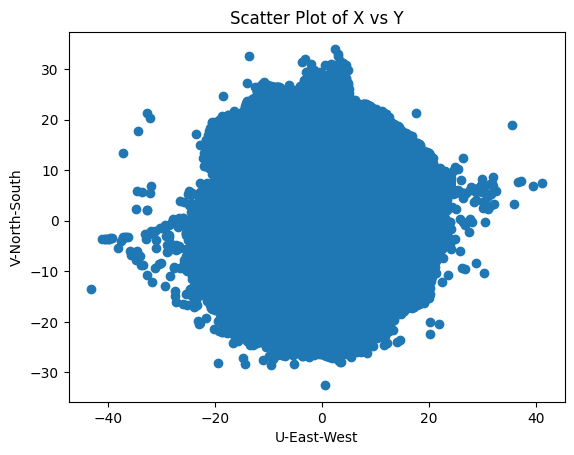

In [23]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is called df and the two variables are 'x' and 'y'
plt.scatter(df['U-East-West'], df['V-North-South'])

# Adding labels and title
plt.xlabel('U-East-West')
plt.ylabel('V-North-South')
plt.title('Scatter Plot of X vs Y')

# Show the plot
plt.show()


# Define the geographic projection (lat/lon, WGS84 datum)

In [8]:
# from pyproj import Proj, transform
from pyproj import Proj, Transformer

In [9]:
proj = Proj(proj='latlon', datum='WGS84')

In [10]:
# Define the projection: Lambert Conformal Conic with standard parallels as min/max latitudes
lat_1 = df['Lat'].min() # Southern latitude (min latitude)
lat_2 = df['Lat'].max()  # Northern latitude (max latitude)
lon_0 = (df['Lon'].min() + df['Lon'].max()) / 2  # Central meridian (midpoint longitude)
lat_0 = (lat_1 + lat_2) / 2  # Latitude of origin (midpoint latitude)

In [11]:
lat_0

38.85417556762695

In [12]:
# Define the source and target CRS (WGS84 to LCC)
source_crs = "EPSG:4326"  # WGS84 (lat/lon)
target_crs = f"+proj=lcc +lat_1={lat_1} +lat_2={lat_2} +lon_0={lon_0} +lat_0={lat_0} +datum=WGS84"

# Create a Transformer object for converting from WGS84 to LCC
transformer = Transformer.from_crs(source_crs, target_crs)

# Convert lat/lon to projected x, y coordinates
df['x'], df['y'] = transformer.transform(df['Lat'].values, df['Lon'].values)

In [13]:
target_crs

'+proj=lcc +lat_1=34.45660400390625 +lat_2=43.251747131347656 +lon_0=-71.37067794799805 +lat_0=38.85417556762695 +datum=WGS84'

In [14]:
df.describe()

,Speed,Direction,Cos(dir),Sen(dir),Lat,Lon,U-East-West,V-North-South,x,y
count,2.231094e+08,2.231094e+08,2.231094e+08,2.231094e+08,2.231094e+08,2.231094e+08,2.231094e+08,2.231094e+08,2.231094e+08,2.231094e+08
mean,7.438950e+00,2.003578e+02,-3.753073e-02,-2.108379e-01,3.872490e+01,-7.026976e+01,-1.822421e+00,2.246867e-01,9.418809e+04,-1.043696e+04
std,4.508317e+00,9.927868e+01,3.878073e-01,3.878073e-01,1.240983e+01,2.481967e+01,4.300898e+00,4.370080e+00,2.277515e+05,2.237590e+05
min,2.802710e-07,0.000000e+00,-1.000000e+00,-1.000000e+00,3.445660e+01,-7.849700e+01,-4.313415e+01,-3.249403e+01,-6.303629e+05,-4.870201e+05
25%,4.679373e+00,1.241069e+02,-7.741582e-01,-8.068214e-01,3.706025e+01,-7.218423e+01,-5.296622e+00,-4.145951e+00,-7.046057e+04,-1.940868e+05
50%,6.859200e+00,2.144234e+02,-4.314137e-02,-4.100640e-01,3.862658e+01,-7.003027e+01,-2.091028e+00,-1.219197e-01,1.153809e+05,-2.139838e+04
75%,9.899419e+00,2.830414e+02,6.703467e-01,3.906952e-01,4.034582e+01,-6.823428e+01,1.863928e+00,4.507663e+00,2.699908e+05,1.682478e+05
max,4.520000e+01,3.600000e+02,1.000000e+00,1.000000e+00,4.325175e+01,-6.424435e+01,4.113009e+01,3.400983e+01,6.322393e+05,4.909357e+05


# Time series visualization

In [15]:
df['Date'] = pd.to_datetime(df['Date'])

In [53]:
df['Date']

0           2019-04-20
1           2019-04-20
2           2019-04-20
3           2019-04-20
4           2019-04-20
               ...    
223109361   2021-01-29
223109362   2021-01-29
223109363   2021-01-29
223109364   2021-01-29
223109365   2021-01-29
Name: Date, Length: 223109366, dtype: datetime64[ns]

In [51]:
df[df[['Date','Lat','Lon']].duplicated()]

,Speed,Direction,Cos(dir),Sen(dir),Lat,Lon,ID,Date,Start Time,End Time,U-East-West,V-North-South,x,y,x_2,y_2
135638361,5.508133,248.472366,-0.366950,-0.930241,39.889069,-70.647446,S1B_IW_OCN__2SDV_20171010T104840_20171010T1049...,2017-10-10,10:48:40,10:49:06,-5.123889,-2.021209,61686.508607,114809.396250,61686.508607,114809.396250
143061102,8.290246,198.123474,-0.950388,-0.311066,38.926277,-66.491890,S1B_IW_OCN__2SDV_20180727T103242_20180727T1033...,2018-07-27,10:32:42,10:33:07,-2.578812,-7.878953,421628.153518,19256.118382,421628.153518,19256.118382
145508391,9.300000,321.994934,0.787956,-0.615731,39.691185,-71.444214,S1B_IW_OCN__2SDV_20200128T104916_20200128T1049...,2020-01-28,10:49:16,10:49:41,-5.726301,7.327993,-6289.807887,92658.102578,-6289.807887,92658.102578
155067345,3.300000,70.257675,0.337791,0.941221,40.861885,-66.611282,S1B_IW_OCN__2SDV_20200306T103209_20200306T1032...,2020-03-06,10:32:09,10:32:34,3.106030,1.114709,400144.637043,232747.375620,400144.637043,232747.375620
159617280,11.500000,299.075104,0.485956,-0.873983,37.660564,-69.782906,S1B_IW_OCN__2SDV_20210926T104143_20210926T1042...,2021-09-26,10:41:43,10:42:08,-10.050810,5.588490,139712.680572,-130898.761340,139712.680572,-130898.761340
165276740,2.300000,252.045731,-0.308258,-0.951303,40.658905,-69.053780,S1B_IW_OCN__2SDV_20210821T104051_20210821T1041...,2021-08-21,10:40:51,10:41:16,-2.187996,-0.708993,195430.850177,202303.410659,195430.850177,202303.410659
165564122,9.332210,287.933258,0.307909,-0.951416,37.838375,-69.131912,S1B_IW_OCN__2SDV_20181223T104123_20181223T1041...,2018-12-23,10:41:23,10:41:48,-8.878812,2.873471,196502.761562,-110021.949075,196502.761562,-110021.949075
175730955,4.500000,267.814117,-0.038142,-0.999272,37.186916,-70.701347,S1B_IW_OCN__2SDV_20191223T104942_20191223T1050...,2019-12-23,10:49:42,10:50:18,-4.496726,-0.171637,59283.407902,-184328.279203,59283.407902,-184328.279203
178300670,9.400000,349.658112,0.983754,-0.179521,37.512974,-70.888496,S1B_IW_OCN__2SDV_20191211T104943_20191211T1050...,2019-12-11,10:49:43,10:50:19,-1.687500,9.247288,42516.829706,-148339.191054,42516.829706,-148339.191054
181601608,5.062902,50.129745,0.641051,0.767498,40.006134,-69.085472,S1B_IW_OCN__2SDV_20180708T104030_20180708T1040...,2018-07-08,10:40:30,10:40:55,3.885767,3.245579,194568.658603,129963.873036,194568.658603,129963.873036


In [22]:
# df

In [23]:
df.set_index('Date', inplace=True)
df_resampled = df.resample('m').agg({'Speed': 'mean'})

/tmp/ipykernel_71139/158758758.py:2: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df.resample('m').agg({'Speed': 'mean'})


In [24]:
df_resampled

,Speed
Date,
2015-07-31,3.569408
2015-08-31,5.302757
2015-09-30,8.214606
2015-10-31,8.774467
2015-11-30,9.515772
...,...
2024-05-31,5.883335
2024-06-30,6.229484
2024-07-31,6.183709


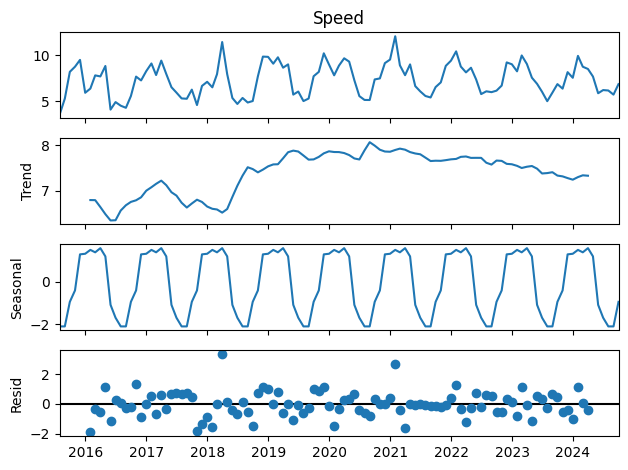

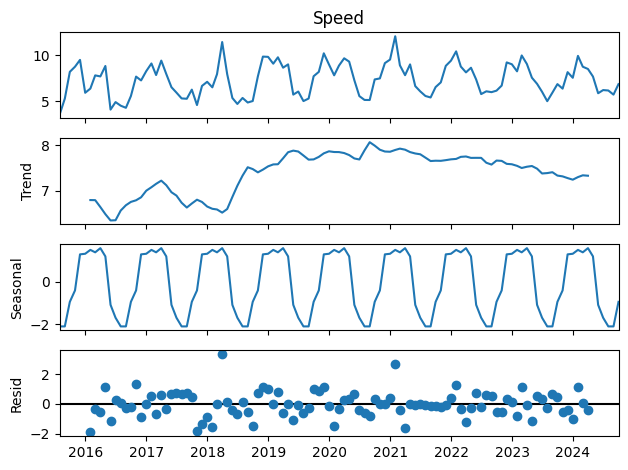

In [26]:
import statsmodels.api as sm
# Decompose the speed time series
result = sm.tsa.seasonal_decompose(df_resampled['Speed'], model='additive', period=12)

# Plot the decomposition
result.plot()

In [27]:
# Calculate a rolling mean (e.g., 30-day window)

df_resampled['Speed_rolling_mean'] = df_resampled['Speed'].rolling(window=30).mean()


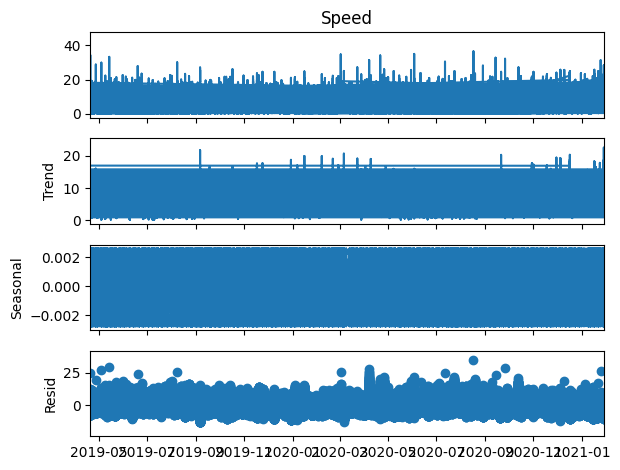

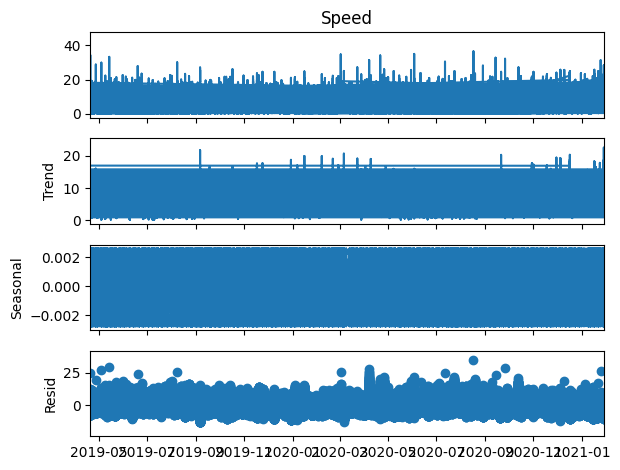

In [28]:
import statsmodels.api as sm

# Decompose the speed time series (with irregular intervals)
result = sm.tsa.seasonal_decompose(df['Speed'], model='additive', period=365)

# Plot the decomposition
result.plot()


/home/noriegac/.conda/envs/cris_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


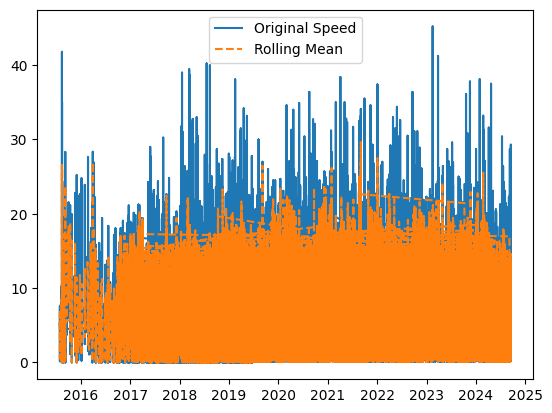

In [29]:
# Calculate a rolling mean with a window of 10 time periods (you can adjust this based on your data)
df['Speed_rolling'] = df['Speed'].rolling(window=10, min_periods=1).mean()

# Plot the original and rolling mean
import matplotlib.pyplot as plt
plt.plot(df.index, df['Speed'], label='Original Speed')
plt.plot(df.index, df['Speed_rolling'], label='Rolling Mean', linestyle='--')
plt.legend()
plt.show()


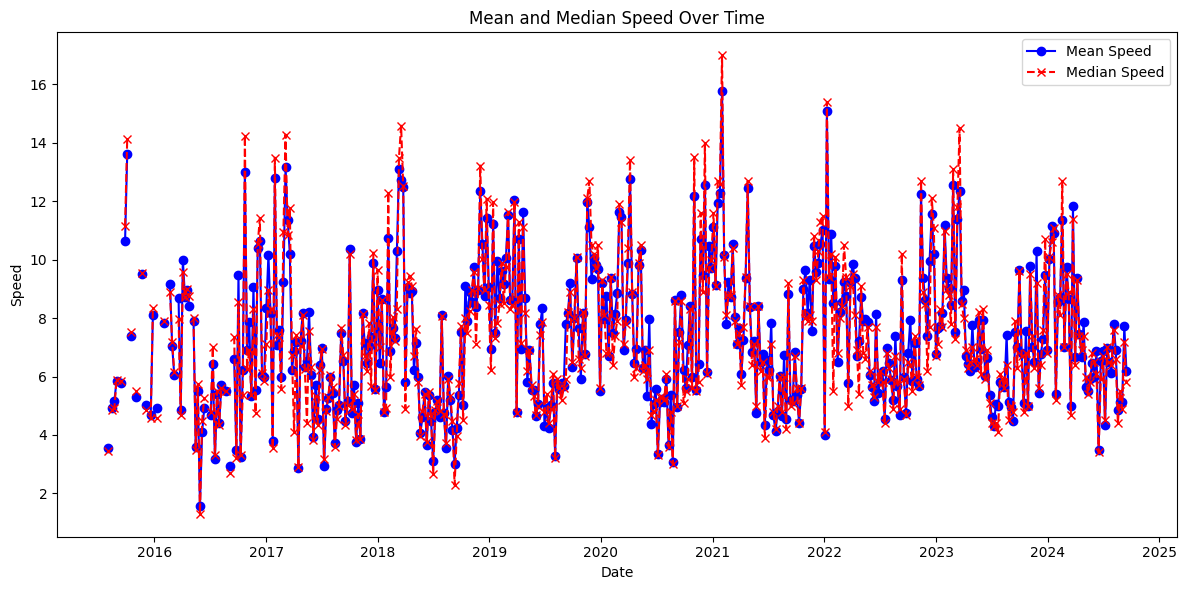

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume 'df' is your DataFrame with 'Timestamp' as datetime index and 'Speed' column

# Step 1: Resample the data
# Since you have irregular intervals, you can resample it to a regular frequency (e.g., daily or weekly)
# Here, I'm resampling to a weekly frequency ('W'), but you can change this to 'D' for daily or any other frequency.

df_resampled = df.resample('W').agg({'Speed': ['mean', 'median']})  # Weekly resampling with mean and median

# Step 2: Plot the results
plt.figure(figsize=(12, 6))

# Plot the mean and median
plt.plot(df_resampled.index, df_resampled['Speed']['mean'], label='Mean Speed', color='blue', linestyle='-', marker='o')
plt.plot(df_resampled.index, df_resampled['Speed']['median'], label='Median Speed', color='red', linestyle='--', marker='x')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Speed')
plt.title('Mean and Median Speed Over Time')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = df[['U-East-West', 'V-North-South', 'x', 'y']].copy()
df_scaled[['U-East-West', 'V-North-South', 'x', 'y']] = scaler.fit_transform(df_scaled[['U-East-West', 'V-North-South', 'x', 'y']])

In [35]:
df_scaled

,U-East-West,V-North-South,x,y
Date,,,,
2019-04-20,0.000825,-1.535690,-1.456850,-1.481035
2019-04-20,0.018307,-1.453423,-1.452522,-1.480323
2019-04-20,0.015581,-1.465301,-1.448194,-1.479612
2019-04-20,0.017573,-1.455220,-1.443867,-1.478899
2019-04-20,0.013904,-1.471471,-1.439536,-1.478187
...,...,...,...,...
2021-01-29,-1.547239,2.174490,-0.224302,-0.100906
2021-01-29,-1.360960,2.182352,-0.228626,-0.100224
2021-01-29,-1.380675,2.127056,-0.232953,-0.099542


# K-Means 

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [6]:
df_scaled_path = os.path.join(INTERIM_DATA_DIR, "df_scaled.pkl")

import pickle

# Open the .pkl file in binary read mode
with open(df_scaled_path, 'rb') as file:
    df_scaled = pickle.load(file)



In [7]:
df_scaled

,U-East-West,V-North-South,x,y
Date,,,,
2019-04-20,0.000825,-1.535690,-1.456850,-1.481035
2019-04-20,0.018307,-1.453423,-1.452522,-1.480323
2019-04-20,0.015581,-1.465301,-1.448194,-1.479612
2019-04-20,0.017573,-1.455220,-1.443867,-1.478899
2019-04-20,0.013904,-1.471471,-1.439536,-1.478187
...,...,...,...,...
2021-01-29,-1.547239,2.174490,-0.224302,-0.100906
2021-01-29,-1.360960,2.182352,-0.228626,-0.100224
2021-01-29,-1.380675,2.127056,-0.232953,-0.099542


In [8]:
X_scaled = df_scaled[['U-East-West', 'V-North-South', 'x', 'y']].values

## Elbow Method to find optimal k (number of clusters)

In [10]:
inertia = []
k_range = range(1, 11)  # Test for k from 1 to 10 clusters

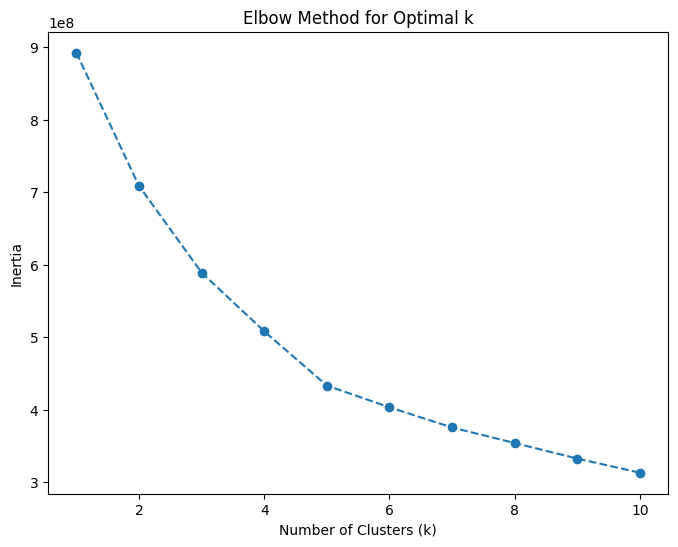

In [40]:


for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


## Silhouette Score to validate clustering performance for different k

In [ ]:
sil_scores = []

for k in k_range[1:6]:  # Start from 2 because silhouette score is undefined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

# Plot the Silhouette scores for different k
plt.figure(figsize=(8, 6))
plt.plot(k_range[1:], sil_scores, marker='o', linestyle='--', color='orange')
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


/home/noriegac/.conda/envs/cris_env/lib/python3.12/site-packages/sklearn/utils/_chunking.py:169: UserWarning: Could not adhere to working_memory config. Currently 1024MiB, 1703MiB required.
  warnings.warn(


## Final K-Means clustering with the optimal number of clusters (e.g., k=3)

In [54]:
optimal_k = 5
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans_final.fit_predict(X_scaled)

# Show the resulting DataFrame with clusters
print(df)


                Speed   Direction  Cos(dir)  Sen(dir)        Lat        Lon  \
Date                                                                          
2019-04-20   9.112082  191.507050 -0.979900 -0.199488  35.735710 -74.001427   
2019-04-20   8.611857  191.513458 -0.979878 -0.199598  35.737404 -73.990570   
2019-04-20   8.684312  191.519867 -0.979855 -0.199708  35.739094 -73.979713   
2019-04-20   8.623184  191.526260 -0.979833 -0.199817  35.740788 -73.968857   
2019-04-20   8.722241  191.532669 -0.979811 -0.199927  35.742477 -73.957993   
...               ...         ...       ...       ...        ...        ...   
2021-01-29  16.900000  321.281860  0.780232 -0.625490  38.554832 -70.874741   
2021-01-29  16.299999  324.274872  0.811827 -0.583897  38.556259 -70.886063   
2021-01-29  16.100000  323.267883  0.801440 -0.598074  38.557686 -70.897392   
2021-01-29  16.400000  322.260895  0.790806 -0.612067  38.559109 -70.908722   
2021-01-29  17.700001  320.253906  0.768885 -0.63938

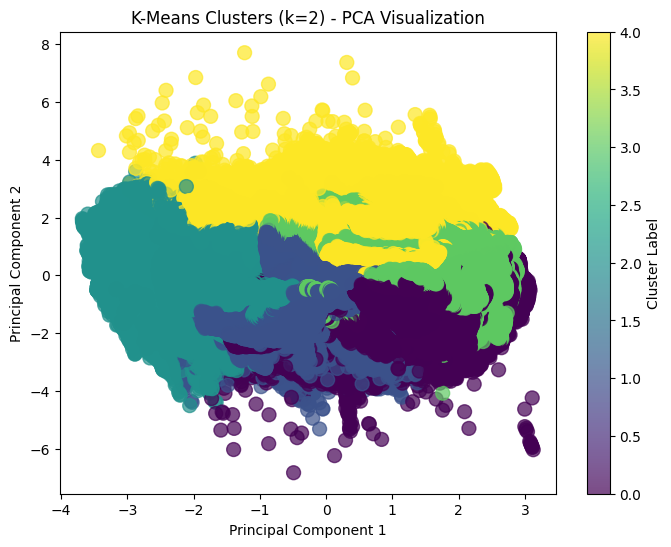

In [57]:
# Reduce the data to 2D using PCA for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis', s=100, alpha=0.7)
plt.title('K-Means Clusters (k=2) - PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


In [45]:
df

,Speed,Direction,Cos(dir),Sen(dir),Lat,Lon,ID,Start Time,End Time,U-East-West,V-North-South,x,y,Speed_rolling
Date,,,,,,,,,,,,,,
2019-04-20,9.112082,191.507050,-0.979900,-0.199488,35.735710,-74.001427,S1A_IW_OCN__2SDH_20190420T224949_20190420T2250...,22:49:49,22:50:14,-1.817755,-8.928930,-237611.571366,-341831.927671,9.112082
2019-04-20,8.611857,191.513458,-0.979878,-0.199598,35.737404,-73.990570,S1A_IW_OCN__2SDH_20190420T224949_20190420T2250...,22:49:49,22:50:14,-1.718909,-8.438569,-236625.873432,-341672.564783,8.861969
2019-04-20,8.684312,191.519867,-0.979855,-0.199708,35.739094,-73.979713,S1A_IW_OCN__2SDH_20190420T224949_20190420T2250...,22:49:49,22:50:14,-1.734324,-8.509371,-235640.228878,-341513.506687,8.802750
2019-04-20,8.623184,191.526260,-0.979833,-0.199817,35.740788,-73.968857,S1A_IW_OCN__2SDH_20190420T224949_20190420T2250...,22:49:49,22:50:14,-1.723060,-8.449283,-234654.613501,-341353.908445,8.757859
2019-04-20,8.722241,191.532669,-0.979811,-0.199927,35.742477,-73.957993,S1A_IW_OCN__2SDH_20190420T224949_20190420T2250...,22:49:49,22:50:14,-1.743809,-8.546147,-233668.362582,-341194.634552,8.750735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29,16.900000,321.281860,0.780232,-0.625490,38.554832,-70.874741,S1B_IW_OCN__2SDV_20210129T104109_20210129T1041...,10:41:09,10:41:34,-10.570777,13.185926,43102.933383,-33015.646602,16.340000
2021-01-29,16.299999,324.274872,0.811827,-0.583897,38.556259,-70.886063,S1B_IW_OCN__2SDV_20210129T104109_20210129T1041...,10:41:09,10:41:34,-9.517527,13.232787,42118.083871,-32863.024808,16.490000
2021-01-29,16.100000,323.267883,0.801440,-0.598074,38.557686,-70.897392,S1B_IW_OCN__2SDV_20210129T104109_20210129T1041...,10:41:09,10:41:34,-9.629000,12.903192,41132.609846,-32710.284125,16.640000


In [50]:
# df_scaled_path = os.path.join(INTERIM_DATA_DIR,"df_scaled.parquet")
# df_scaled.to_parquet(df_scaled_path, compression='snappy')

df_scaled_path = os.path.join(INTERIM_DATA_DIR, "df_scaled.pkl")

# Save the DataFrame as a pickle file
df_scaled.to_pickle(df_scaled_path)

In [4]:
df_path = os.path.join(INTERIM_DATA_DIR,"df.pkl")
# df.to_pickle(df_path)

In [56]:
import joblib
kmeans_model_path = os.path.join(INTERIM_DATA_DIR,"kmeans_model.pkl")

# Assuming `kmeans` is your trained KMeans model
joblib.dump(kmeans_final, kmeans_model_path)

['/nfs/storage1/home/noriegac/Documents/Offshore_Wind_Research/data/interim/kmeans_model.pkl']

In [25]:
gdb_path = os.path.join(INTERIM_DATA_DIR, "geodatabase_df.gdb")

In [ ]:
import geopandas as gpd
import pandas as pd
# Convert your DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, 
                       geometry=gpd.points_from_xy(df['Lon'], df['Lat']))

# Set the CRS (Coordinate Reference System) if needed (e.g., WGS84)
gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)

# Save the GeoDataFrame as a Shapefile or GeoJSON
gdf.to_file('data.shp')  # Save as a shapefile
gdf.to_file('data.geojson', driver='GeoJSON')  # Save as a GeoJSON file

/tmp/ipykernel_59094/1142332200.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('data.shp')  # Save as a shapefile
/home/noriegac/.conda/envs/cris_env/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Field Date create as date field, though DateTime requested.
  ogr_write(
/home/noriegac/.conda/envs/cris_env/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'U-East-West' to 'U-East-Wes'
  ogr_write(
/home/noriegac/.conda/envs/cris_env/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'V-North-South' to 'V-North-So'
  ogr_write(
/home/noriegac/.conda/envs/cris_env/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Speed_rolling' to 'Speed_roll'
  ogr_write(


In [9]:
import pickle
with open(df_path, 'rb') as file:
    df = pickle.load(file)

df = df.reset_index()
df = df.sort_values(by='Date')

# df#.columns

In [10]:
df

,Date,Speed,Direction,Cos(dir),Sen(dir),Lat,Lon,ID,Start Time,End Time,U-East-West,V-North-South,x,y,Speed_rolling,Cluster
183460,2015-07-31,3.195712,242.784668,-0.457336,-0.889294,41.420609,-67.115166,S1A_IW_OCN__2SDV_20150731T222600_20150731T2226...,22:26:00,22:26:28,-2.841928,-1.461514,354926.586615,292502.944622,2.938439,3
168289,2015-07-31,3.850311,227.866150,-0.670865,-0.741580,41.972977,-67.131004,S1A_IW_OCN__2SDV_20150731T222600_20150731T2226...,22:26:00,22:26:28,-2.855312,-2.583038,350761.714350,353619.356816,4.219795,3
168288,2015-07-31,3.997283,227.858398,-0.670965,-0.741489,41.971497,-67.142899,S1A_IW_OCN__2SDV_20150731T222600_20150731T2226...,22:26:00,22:26:28,-2.963941,-2.682037,349785.976222,353409.715783,4.269433,3
168287,2015-07-31,4.126301,227.850647,-0.671066,-0.741398,41.970020,-67.154816,S1A_IW_OCN__2SDV_20150731T222600_20150731T2226...,22:26:00,22:26:28,-3.059232,-2.769019,348808.277487,353200.536362,4.291078,3
168286,2015-07-31,4.081937,227.842865,-0.671166,-0.741307,41.968540,-67.166725,S1A_IW_OCN__2SDV_20150731T222600_20150731T2226...,22:26:00,22:26:28,-3.025968,-2.739658,347831.180352,352991.090384,4.311975,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174936802,2024-09-15,9.700000,76.727539,0.229582,0.973289,39.054546,-69.867584,S1A_IW_OCN__2SDV_20240915T224231_20240915T2242...,22:42:31,22:42:56,9.440907,2.226945,129720.529003,23247.395409,9.570000,4
174936801,2024-09-15,9.400000,75.720421,0.246654,0.969104,39.053120,-69.878990,S1A_IW_OCN__2SDV_20240915T224231_20240915T2242...,22:42:31,22:42:56,9.109574,2.318544,128738.838912,23073.338745,9.550000,4
174936800,2024-09-15,9.100000,76.713295,0.229824,0.973232,39.051693,-69.890396,S1A_IW_OCN__2SDV_20240915T224231_20240915T2242...,22:42:31,22:42:56,8.856414,2.091397,127757.107330,22899.404532,9.600000,4
174936807,2024-09-15,9.500000,79.763153,0.177718,0.984082,39.061661,-69.810539,S1A_IW_OCN__2SDV_20240915T224231_20240915T2242...,22:42:31,22:42:56,9.348774,1.688317,134629.709254,24117.426774,9.390000,4


In [12]:
cluster_dfs = {}  # Create an empty dictionary to store DataFrames

for cluster in df['Cluster'].unique():
    cluster_dfs[cluster] = df[df['Cluster'] == cluster]


In [13]:
df_cluster_0 = cluster_dfs[0]
df_cluster_1 = cluster_dfs[1]
df_cluster_2 = cluster_dfs[2]
df_cluster_3 = cluster_dfs[3]
df_cluster_4 = cluster_dfs[4]



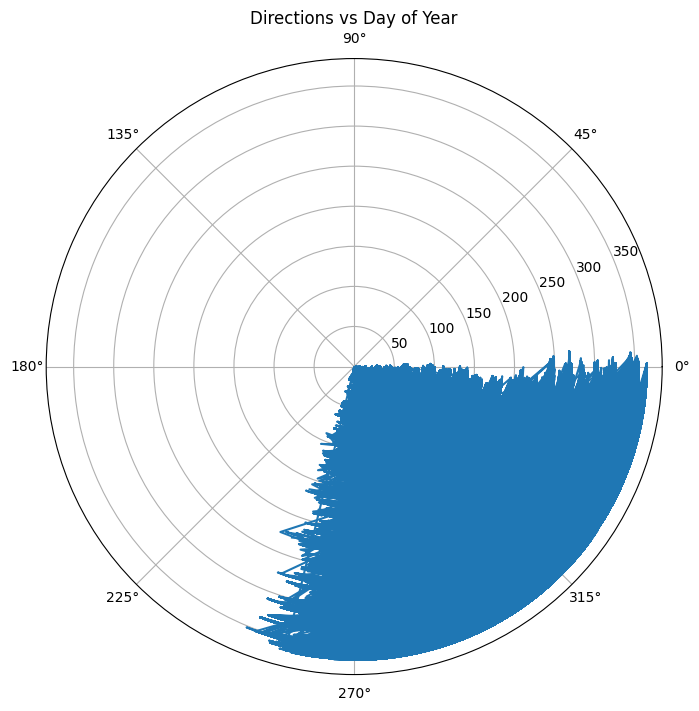

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Increase the chunk size to avoid OverflowError
mpl.rcParams['agg.path.chunksize'] = 10000  # Increase this if you still face the error

# Sample DataFrame (replace this with your actual df)
# df_cluster_0 = pd.DataFrame({
#     'Date': pd.date_range(start='2024-01-01', periods=12, freq='M'),  # Monthly data
#     'Direction': np.random.uniform(0, 360, 12)  # Random directions between 0° and 360°
# })

# Ensure that we are modifying the DataFrame correctly (use .loc to avoid SettingWithCopyWarning)
df_cluster_0.loc[:, 'DayOfYear'] = df_cluster_0['Date'].dt.dayofyear

# Plot the data on a polar plot
plt.figure(figsize=(10, 8))

# Plot: directions as angles and day of the year as magnitudes
plt.polar(np.radians(df_cluster_0['Direction']), df_cluster_0['DayOfYear'])

# Add title and show the plot
plt.title('Directions vs Day of Year')
plt.show()


In [18]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

In [19]:
cluster_counts_by_month = df.groupby(['Year','Month', 'Cluster']).size().reset_index(name='Count')

In [22]:
pivot_data = cluster_counts_by_month.pivot_table(index=['Year', 'Month'], columns='Cluster', values='Count', aggfunc='sum').fillna(0).reset_index()

In [30]:
pivot_data['Year-Month'] = pivot_data['Year'].astype(str) + '-' + pivot_data['Month'].astype(str).str.zfill(2)

In [34]:
pivot_data['Year-Month']

0      2015-07
1      2015-08
2      2015-09
3      2015-10
4      2015-11
        ...   
106    2024-05
107    2024-06
108    2024-07
109    2024-08
110    2024-09
Name: Year-Month, Length: 111, dtype: object

TypeError: unsupported operand type(s) for +: 'float' and 'str'

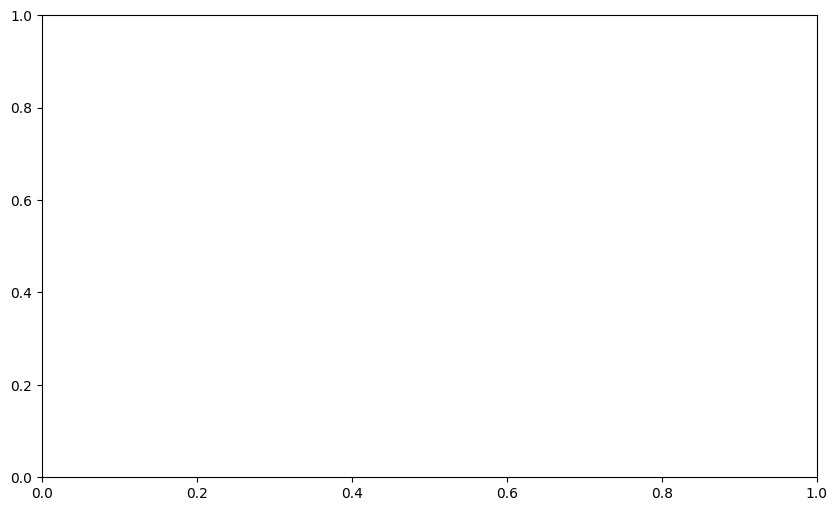

In [32]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot a stacked area chart
plt.stackplot(pivot_data['Year-Month'].values, pivot_data.values.T, labels=pivot_data.columns, alpha=0.6, cmap='Set2')
plt.legend(title='Cluster')

# Show the plot
plt.tight_layout()
plt.show()

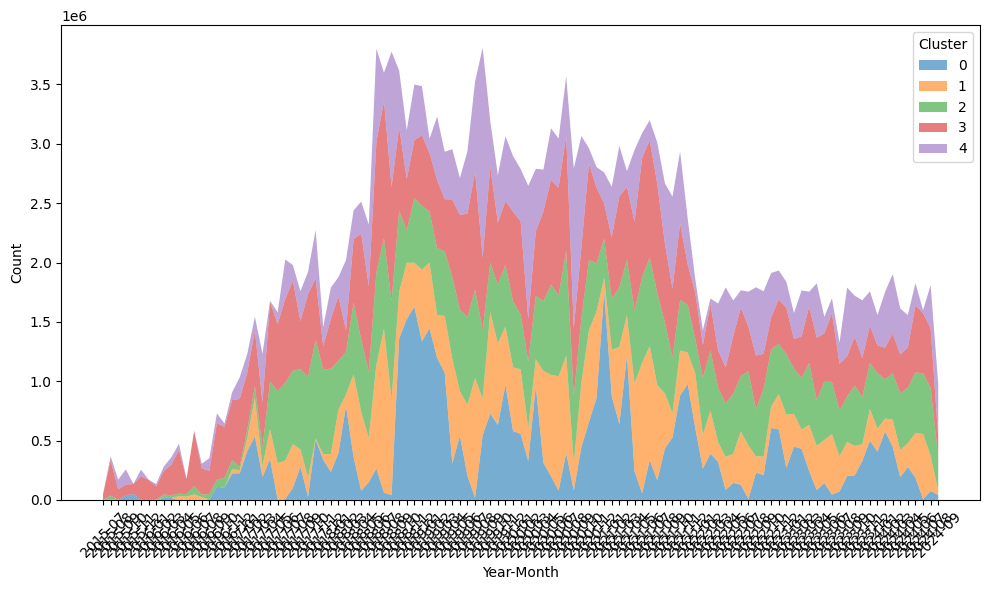

In [35]:
import matplotlib.pyplot as plt

# Ensure that 'Year' and 'Month' are integers or strings (and handle NaN values if any)
pivot_data['Year'] = pivot_data['Year'].astype(int)  # Convert Year to integer
pivot_data['Month'] = pivot_data['Month'].astype(int)  # Convert Month to integer

# Add a new 'Year-Month' column by combining 'Year' and 'Month'
pivot_data['Year-Month'] = pivot_data['Year'].astype(str) + '-' + pivot_data['Month'].astype(str).str.zfill(2)

# Now that we've fixed the types, we can proceed with plotting
plt.figure(figsize=(10, 6))

# Plot a stacked area chart
plt.stackplot(pivot_data['Year-Month'], pivot_data.drop(columns=['Year', 'Month', 'Year-Month']).values.T, 
              labels=pivot_data.columns[2:], alpha=0.6, cmap='Set2')  # Exclude Year and Month columns from x-axis

# Add legend and labels
plt.legend(title='Cluster')
plt.xlabel('Year-Month')
plt.ylabel('Count')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


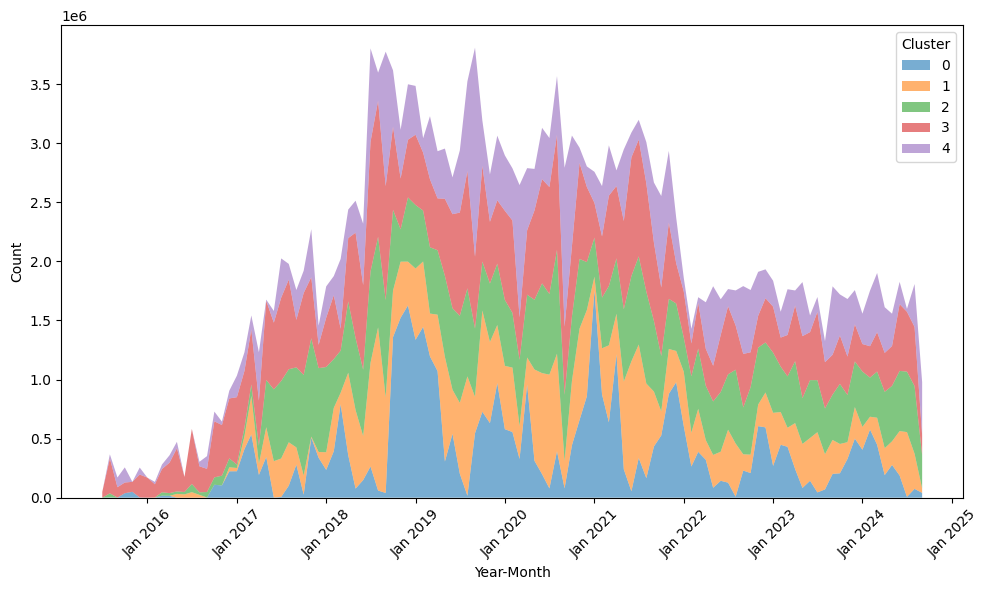

In [36]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure that 'Year' and 'Month' are integers
pivot_data['Year'] = pivot_data['Year'].astype(int)
pivot_data['Month'] = pivot_data['Month'].astype(int)

# Add a new 'Year-Month' column by combining 'Year' and 'Month'
pivot_data['Year-Month'] = pd.to_datetime(pivot_data['Year'].astype(str) + '-' + pivot_data['Month'].astype(str).str.zfill(2))

# Now that we've fixed the types, we can proceed with plotting
plt.figure(figsize=(10, 6))

# Plot a stacked area chart
plt.stackplot(pivot_data['Year-Month'], pivot_data.drop(columns=['Year', 'Month', 'Year-Month']).values.T, 
              labels=pivot_data.columns[2:], alpha=0.6, cmap='Set2')  # Exclude Year and Month columns from x-axis

# Add legend and labels
plt.legend(title='Cluster')
plt.xlabel('Year-Month')
plt.ylabel('Count')

# Format x-axis to show month names (e.g., 'Jan 2020', 'Feb 2020', ...)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


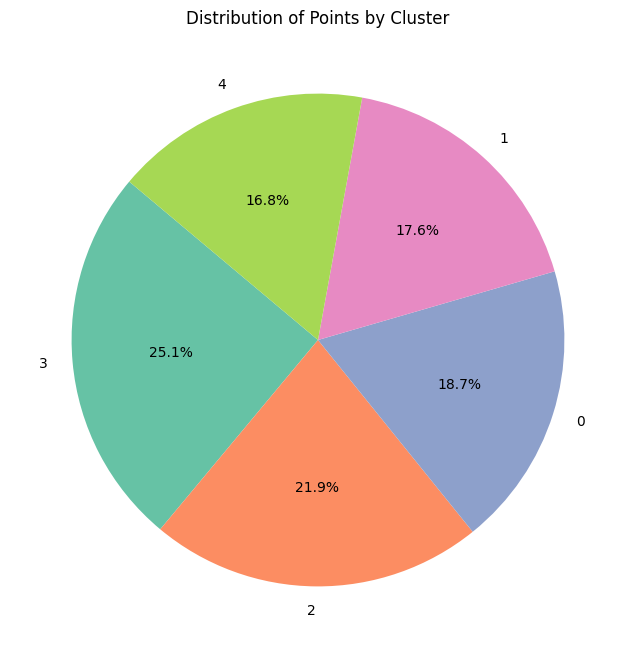

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Count the number of points by cluster
cluster_counts = df['Cluster'].value_counts()  # Count occurrences of each cluster

# Step 2: Get a color palette
colors = sns.color_palette('Set2', len(cluster_counts))  # 'Set2' palette, with as many colors as clusters

# Step 3: Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)

# Add title
plt.title('Distribution of Points by Cluster')

# Show the plot
plt.show()


In [41]:
pivot_data

Cluster,Year,Month,0,1,2,3,4,Year-Month
0,2015,7,0.0,0.0,0.0,48829.0,0.0,2015-07-01
1,2015,8,2577.0,0.0,33996.0,296088.0,34262.0,2015-08-01
2,2015,9,338.0,0.0,640.0,87654.0,82396.0,2015-09-01
3,2015,10,37763.0,0.0,38.0,90473.0,128268.0,2015-10-01
4,2015,11,49673.0,0.0,0.0,84634.0,36.0,2015-11-01
...,...,...,...,...,...,...,...,...
106,2024,5,277368.0,199727.0,469564.0,337095.0,273596.0,2024-05-01
107,2024,6,187532.0,376344.0,509233.0,565423.0,188515.0,2024-06-01
108,2024,7,6849.0,548241.0,511766.0,506599.0,24536.0,2024-07-01
109,2024,8,74948.0,297293.0,572581.0,500676.0,363041.0,2024-08-01


In [43]:
pivot_data.columns[2:-1]

Index([0, 1, 2, 3, 4], dtype='object', name='Cluster')

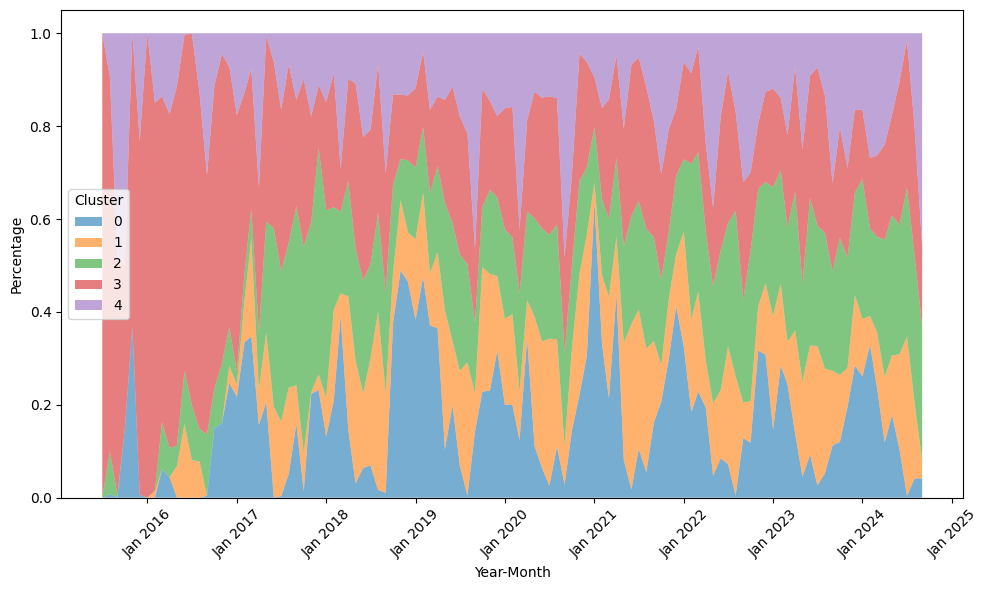

In [44]:

# Exclude non-numeric columns (Year, Month, Year-Month) from the normalization
numeric_columns = pivot_data.columns[2:-1]  # Assuming clusters are in columns starting from the 3rd one
pivot_data_normalized[numeric_columns] = pivot_data[numeric_columns].div(pivot_data[numeric_columns].sum(axis=1), axis=0)

# Now that we've normalized the data, we can proceed with plotting
plt.figure(figsize=(10, 6))

# Step 2: Plot the stacked area chart with normalized values (percentages)
plt.stackplot(pivot_data_normalized['Year-Month'], 
              pivot_data_normalized[numeric_columns].values.T, 
              labels=pivot_data.columns[2:], alpha=0.6, cmap='Set2')

# Add legend and labels
plt.legend(title='Cluster')
plt.xlabel('Year-Month')
plt.ylabel('Percentage')

# Format x-axis to show month names (e.g., 'Jan 2020', 'Feb 2020', ...)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()
